# The basics of making a moving sound... 
### (1) a simple sine wave x a simple envelope
### (2) calculate the position in time of the beep source
### (3) calculate the weights for each channel for that sound (stereo and 4 channel)
### (4) create the sound channels and add weighted beeps at times. 
### (6) ways to add to this ! 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt # for plots

from scipy import fftpack as spfft # for computing spectra
#from scipy import signal as spsig
import librosa

# our codes: 
import sys
sys.path.append('../2_modules/')
import position_generator_1D as pos_gen
from importlib import reload   # reload it below
 
% matplotlib inline

In [2]:
#make a function to make a single frequency beep...  

def make_beep(dur,f,sr):
    p = 1/f
    n_cycles = dur/p
    n_pts = int(np.floor(dur*sr))
    
    t = np.linspace(0,dur,n_pts)
    #osc = exp**(jj*t) # the other way... useful..     
    x = np.linspace(0,2*np.pi*n_cycles,n_pts) # radians, not time ! but also is time. 
    y_osc = np.sin(x) 
    
    return t,y_osc

def make_env_tri(t,peak_pos_01):
    N = len(t)
    env = np.zeros(N)
    peak_ind = int(np.floor(peak_pos_01*N))
    
    # from 0 to the peak index (peak):
    up = np.linspace(0,1,peak_ind)
    env[:peak_ind] = up
    # and fill in the rest: 
    down = np.linspace(1,0,(N-peak_ind))
    env[peak_ind:] = down
    
    return env

13230


Text(0,0.5,'amplitude of wave')

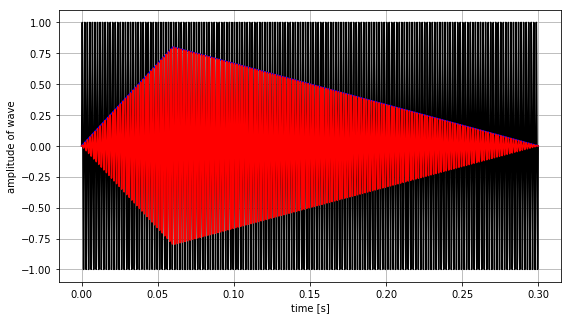

In [22]:
# make the waveform and envelope for one beep. 
# make vectors of two frequencies, that have the same number of points, long enough to hear

dur = 0.3 # in seconds
sr = 44100 # samples/sec
f = 600. # frequency
peak_pos_01 = 0.2 # where the peak of the triangular envelope is
a_scale = 0.8

t,y_osc = make_beep(dur,f,sr)
env = make_env_tri(t,peak_pos_01)
# modulate the signal by multiplication
env = env*a_scale
y = y_osc*env

print(len(y))


# plot the wave
plt.figure(figsize=(9,5))
plt.plot(t,y_osc,'k') 
plt.xlabel('time [s]')
plt.ylabel('amplitude of wave')
plt.grid()

# plot the envelope
plt.plot(t,env,'b') 
plt.plot(t,y,'r') 
plt.xlabel('time [s]')
plt.ylabel('amplitude of wave')

# write the sound: 
# outfile = 'sound_1env.wav'
# librosa.output.write_wav(outfile, y, int(sr), norm=False)

### add some complexity to the beep here-- overtones, etc...

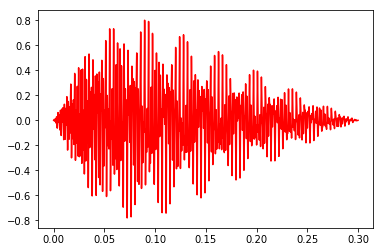

In [28]:
dur = 0.3 # in seconds
a_scale = 0.8

f_vec = [260.0, 494.0, 783.0]
peak_pos_vec = [0.3,0.2,0.1]

y_comp = np.zeros(int(dur*sr))

for ind,f in enumerate(f_vec):
    peak_pos = peak_pos_vec[ind] # where the peak of the triangular envelope is

    t,y_osc = make_beep(dur,f,sr)
    env = make_env_tri(t,peak_pos)
    y_comp = y_comp+(y_osc*env)
    
# modulate the signal by multiplication
y = y_comp/max(y_comp)*a_scale


plt.plot(t,y,'r') 

# write the sound: 
outfile = 'sound_OW.wav'
librosa.output.write_wav(outfile, y, int(sr), norm=False)

# # concatenating
# print(y2.shape)
# yc = np.concatenate((y1,y2),axis=0)
# outfile = 'sound_conc.wav'
# a_scale = 0.6
# librosa.output.write_wav(outfile, yc*a_scale, fs, norm=False)

# MOTION OF BEEPS ! 
### Zhouyao's code

In [53]:
reload(pos_gen)

pos_gen.initialize(0)

list = [0,2,1,3,2,1,0]
pos_gen.move(list)
s = pos_gen.s
npos = len(s)

print(s[0:5])
print(s[-5:-1])
# or reading the pickles: 
# posdf = pd.read_pickle('./position_generator/position_data_1.pickle')
# posdf.shape

   position  time
0      0.00   0.0
1      0.00   0.1
2      0.05   0.2
3      0.10   0.3
4      0.15   0.4
     position  time
157      0.20  15.7
158      0.15  15.8
159      0.10  15.9
160      0.05  16.0


dur_track (total duration of sound) =  16.1


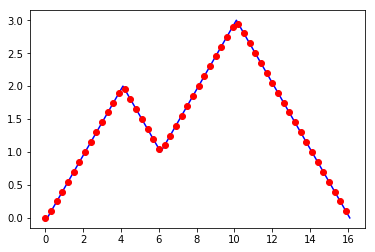

In [56]:
# subsample ? 

time = np.asarray(s.time)
posn = np.asarray(s.position)

dur_track = time[-1]
print('dur_track (total duration of sound) = ', str(dur_track))
# subsample to get beep times ! 
subsam = 3
time_beep = time[0::subsam]
posn_beep = posn[0::subsam]

plt.plot(time,posn,'b') 
plt.plot(time_beep,posn_beep,'ro') 

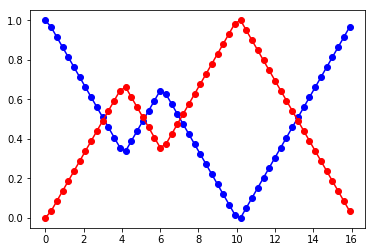

In [58]:
# make the scale factors or weights W for amplitude by position

# stereo version (the left and right channels correspond directly to the min and max of the position values: 

# normalize, normalized distances: 
posn_beep_n = posn_beep/max(posn_beep)
left_distance = posn_beep_n # np.sqrt(0**2 + posn_beep**2) 
right_distance = 1 - posn_beep_n # np.sqrt(1 - posn_beep**2 ) # np.sqrt(1**2 - posn_beep**2 ) 

# weights are just 1-distance, for the simple stereo version, 
# but more complex functions will be needed. 
W_left = 1 - left_distance 
W_right = 1 - right_distance 

plt.plot(time_beep,W_left,'b-') 
plt.plot(time_beep,W_left,'bo') 
plt.plot(time_beep,W_right,'r-') 
plt.plot(time_beep,W_right,'ro') 

In [61]:
# make the SOUNDTRACKS ! 
dt_extra = 1.0 # time to add on to the end for the last beep
n_samp = int((dur_track+dt_extra)*sr)

# make a sounds track of zeros :   (# alternative: concatenate, but that's more complicated) 
time_sound = np.linspace(0,dur_track+dt_extra,n_samp)
channel_left = np.zeros(n_samp) 
channel_right = np.zeros(n_samp) 

print(channel_left.shape)
print(time_sound)

(754110,)
[  0.00000000e+00   2.26757670e-05   4.53515341e-05 ...,   1.70999546e+01
   1.70999773e+01   1.71000000e+01]


In [63]:
# function to find the location in the time vector of where each beep will be added to the sound

def find_first_t(time_sound, t_bp):
    ind = np.argmax(time_sound>t_bp)
    return ind

# other ways: 

        #if t_bp > t: 
        #    break
    #return time_sound.index(i_t)
       
# or this: 
# bisect_left(alist, value)  
# experiment with this later

In [64]:

for i_samp, t_samp in enumerate(time_beep):
    #print(t_samp)
    # find where in the time_sound each time_beep occurs: 
    i_bp = find_first_t(time_sound, t_samp)
    #print(i_bp)
    
    # make beep
    # for now, nothing is changing with the beep other than the weight determined here, 
    # so we can just use the curve defined above instead of re-calling the functions. 
    # to change pitch or duration or whatnot, the make_beep function would be called here. 
    
    w_l = W_left[i_samp]
    y_w_l = y*w_l
    
    w_r = W_right[i_samp]
    y_w_r = y*w_r
    # add it to the soundtracks (l + r)
    channel_left[i_bp:i_bp+len(y_w_l)] = y_w_l
    channel_right[i_bp:i_bp+len(y_w_r)] = y_w_r

    
#W_right

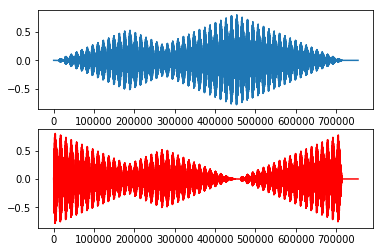

In [65]:
plt.subplot(2,1,1)
plt.plot(channel_right)
plt.subplot(2,1,2)
plt.plot(channel_left, 'r')

In [66]:
# merge into one array to make sound file
# [2,:]
print(len(channel_right))
snd = np.zeros([2,len(channel_right)])
print(snd.shape)
snd[0,:] = channel_left
snd[1,:] = channel_right

754110
(2, 754110)


In [67]:
# write the sound: 
outfile = 'sound_moving_stereo.wav'
librosa.output.write_wav(outfile, snd, int(sr), norm=False)